### Document Parsing with Qwen2.5-VL

Welcome to this notebook, which showcases the powerful document parsing capabilities of our model. It can process any image and output its content in various formats such as HTML, JSON, MD, and LaTeX. Notably, we introduce a unique Qwenvl HTML format that includes positional information for each component, enabling precise document reconstruction and manipulation.

#### \[Setup\]

Load visualization utils.

In [1]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install qwen-vl-utils
# !pip install qwen_agent
# !pip install openai

In [2]:
# Get Noto font
# !apt-get install fonts-noto-cjk 

import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox(image_path, resized_width, resized_height, full_predict):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    original_width = image.width
    original_height = image.height
    
    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)
        
        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized
            
        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    image.show()

# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

Load model and processors.

In [3]:
# #If accessing via API, you can skip this step and directly use the inference_with_api function.
# import torch
# from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
# model_path = "Qwen/Qwen2.5-VL-72B-Instruct"
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
# processor = AutoProcessor.from_pretrained(model_path)

Load inference 

In [4]:
# def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=32000):
#   image = Image.open(img_url)
#   messages = [
#     {
#       "role": "system",
#       "content": system_prompt
#     },
#     {
#       "role": "user",
#       "content": [
#         {
#           "type": "text",
#           "text": prompt
#         },
#         {
#           "image": img_url
#         }
#       ]
#     }
#   ]
#   text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#   print("input:\n",text)
#   inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

#   output_ids = model.generate(**inputs, max_new_tokens=1024)
#   generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
#   output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
#   print("output:\n",output_text[0])

#   input_height = inputs['image_grid_thw'][0][1]*14
#   input_width = inputs['image_grid_thw'][0][2]*14

#   return output_text[0], input_height, input_width

inference function with API

In [5]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen/Qwen2.5-VL-72B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        api_key=os.getenv("MODELSCOPE_SDK_TOKEN"),
        base_url="https://api-inference.modelscope.cn/v1/"
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

#### 1. Document Parsing in QwenVL HTML Format

Here shows how to generate and process HTML content using Qwen2.5-VL. The generated HTML follows the QwenVL Document Parser format with bounding boxes.

1540 1008
```html
<html><body>
<h1 data-bbox="309 96 658 127">Qwen2.5 Technical Report</h1> 
 <p data-bbox="429 156 541 181"></p> 
 <address class="author"><p>Qwen Team</p></address> 
 <p data-bbox="268 198 589 224">😊 <a>https://huggingface.co/Qwen</a></p> 
 <p data-bbox="265 222 707 247">🤗 <a>https://modelscope.cn/organization/qwen</a></p> 
 <p data-bbox="271 246 648 271">🔗 <a>https://github.com/QwenLM/Qwen2.5</a></p> 
 <h2 data-bbox="438 291 533 316">Abstract</h2> 
 <p data-bbox="100 341 868 564">In this report, we introduce Qwen2.5, a comprehensive series of large language models (LLMs) designed to meet diverse needs. Compared to previous iterations, Qwen 2.5 has been significantly improved during both the pre-training and post-training stages. In terms of pre-training, we have scaled the high-quality pre-training datasets from the previous 7 trillion tokens to 18 trillion tokens. This provides a strong foundation for common sense, expert knowledge, and reasoning capabilities. In te

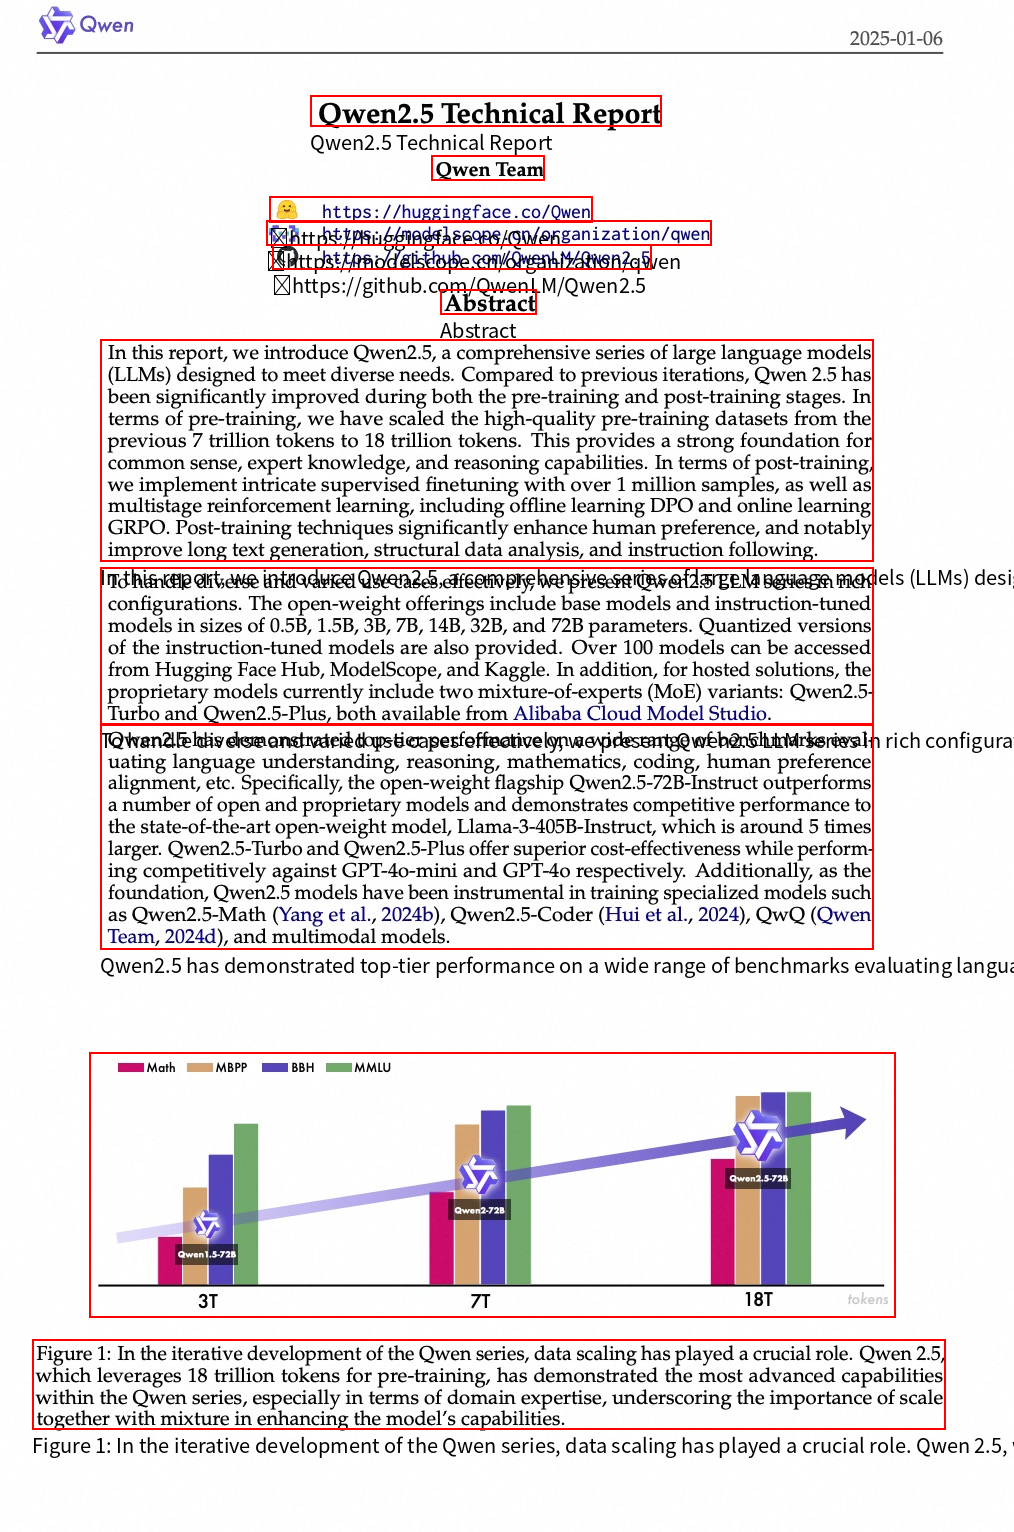

```html
<html><body>
<h1>Qwen2.5 Technical Report</h1> 
 <p></p> 
 <address class="author"><p>Qwen Team</p></address> 
 <p>😊 <a>https://huggingface.co/Qwen</a></p> 
 <p>🤗 <a>https://modelscope.cn/organization/qwen</a></p> 
 <p>🔗 <a>https://github.com/QwenLM/Qwen2.5</a></p> 
 <h2>Abstract</h2> 
 <p>In this report, we introduce Qwen2.5, a comprehensive series of large language models (LLMs) designed to meet diverse needs. Compared to previous iterations, Qwen 2.5 has been significantly improved during both the pre-training and post-training stages. In terms of pre-training, we have scaled the high-quality pre-training datasets from the previous 7 trillion tokens to 18 trillion tokens. This provides a strong foundation for common sense, expert knowledge, and reasoning capabilities. In terms of post-training, we implement intricate supervised finetuning with over 1 million samples, as well as multistage reinforcement learning, including offline learning DPO and online learning GRPO. Post-t

In [6]:
img_url = "assets/document_parsing/docparsing_example6.png"
# image = Image.open(img_url)

system_prompt="You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity."
prompt =  "QwenVL HTML "

## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)




# Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
os.environ['MODELSCOPE_SDK_TOKEN'] = 'f04a1e88-dfe6-4b5b-8828-dab5c9b7987e'
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(img_url)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)


# Visualization
print(input_height, input_width)
print(output)
draw_bbox(img_url, input_width, input_height, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)

#### 2. Generate ordinary html with Qwen2.5-VL

In [7]:
# # generate ordinary html

# img_url = "assets/document_parsing/docparsing_example5.png"
# prompt = "图片解析成html"
# image = Image.open(img_url)

# ## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)
# print(output)

# ## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# # from qwen_vl_utils import smart_resize
# # os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# # min_pixels = 512*28*28
# # max_pixels = 2048*28*28
# # image = Image.open(img_url)
# # width, height = image.size
# # input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
# # output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
# # print(output)